**Jesus M. Castagnetto**


*Project for the "Regression Models" course at Coursera, January 2015 session.
Source at: https://github.com/jmcastagnetto/regmod-jan2015-project/blob/master/project-regmod-jan2015-jmcastagnetto.Rmd*

*Note*: This is an edited version of the Rmarkdown version, mainly due to the inability of IPython/Jupyter to grok latex label references, or embedding R code in between the markdown text. Compare the PDF generated from this notebook with the one generated from the Rmarkdown document.


In [3]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Executive Summary

If we consider only the type of transmission, on average, manual trumps over
automatic (24.39 mpg vs 17.15 mpg), 
with a difference that is statistically significant (p-value < 0.01, and 
confidence interval that does not contain zero). This is confirmed by a t-test
and also the corresponding simple regression model "`mpg ~ am`" (Model 1). Nevertheless,
this model only explains ~36% of the variance in fuel consumption. Further analysis produces a better model, where the fuel usage depends on: the
type of transmission, the car weight, the engine's number of cylinders, and
the engine power ("`mpg ~ cyl + hp + wt + am`", Model 2). This second model is capable of
explaining ~86.6% of the variance in the data.

# Exploratory data analysis

The `mtcars` dataset [^henderson], contains information on 32 cars (1973-1974 
models) and 11 characteristics recorded for each one. I decided to distinguish
between numeric and factor variables, and recode the latter as such:

[^henderson]: Henderson, H.V. and Velleman, P.F. (1981), "Building multiple regression models interactively". *Biometrics*, 37, 391-411.

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(pander)
library(xtable)

In [5]:
%%R
data(mtcars)
mtcars$cyl <- factor(mtcars$cyl)
mtcars$vs <- factor(mtcars$vs, levels=c(0, 1), labels=c("V-engine", "Straight"))
mtcars$am <- factor(mtcars$am, levels=c(0, 1), labels=c("Automatic", "Manual"))
mtcars$gear <- factor(mtcars$gear)
mtcars$carb <- factor(mtcars$carb)

# correlation with mpg
cmpg <- cor(mtcars[, c("mpg", "disp", "hp", "drat", "wt","qsec")])[1,]

# comparison auto/manual
mpg.auto <- subset(mtcars, am=="Automatic")$mpg
mpg.manual <- subset(mtcars, am=="Manual")$mpg
mpg.summ <- mtcars %>% group_by(am) %>% 
    summarise(Median=median(mpg),
              Avg=mean(mpg), 
              SD=sd(mpg),
              Min=min(mpg),
              Max=max(mpg))
names(mpg.summ) <- c("Transm.", names(mpg.summ)[-1])

# t-test
t1 <- t.test(mpg.manual, mpg.auto)

Plots of `mpg` vs factor variables (Fig. 1), indicate that there
are differences in fuel consumption between the different classes, e.g. 
cars with manual transmission seem to fare better than the ones with automatic.
Similar trends are observed for those with 4 cylinder motors, and straight 
engines, which seem to have better mileage than their corresponding counterparts.

If we now look at plots of the numeric variables (Fig. 2), we 
observe strong negative correlations between `mpg` and `disp`
(-0.85), `hp` (-0.78) and `wt` (-0.87), i.e. heavy cars with big and powerful engines consume 
more, which intutively makes sense. Positive correlations are lower in magnitude
and occur between `mpg` and `drat` (0.68) or `qsec` (0.42).

# An initial model: Fuel consumption as a function of car's transmission type

In Fig. 3(a) we can see that there is a distinctive improvement
in fuel usage for cars with manual transmission. The observed mean
difference is 7.24 mpg, and a t-test (_vide infra_), 
gives results that are statistically significant: a p-value < 0.01, and a
95% confidence interval ([3.21, 11.28]) that does not include zero.

In [6]:
%%R
pander(t1, caption="t-Test results: automatic vs manual", style="grid")



+------------------+-------+----------------+--------------------------+
|  Test statistic  |  df   |    P value     |  Alternative hypothesis  |
+==================+=======+================+==========================+
|      3.767       | 18.33 | _0.001374_ * * |        two.sided         |
+------------------+-------+----------------+--------------------------+

Table: t-Test results: automatic vs manual



The simple regression model: "`mpg ~ am`", gives us coefficients that are statistically
significant (see Table below): p-values < 0.01 as well as reasonable confidence intervals. 
In fact $\beta_1$ (=7.24) is, as expected, equal to the difference of the means 
calculated earlier, and indicates us that on average, there is an *improvement of 7.24 mpg* for cars
with manual transmission. But this simple model only explains about 36% of the variance at best 
($R^2=0.3598$, adjusted-$R^2=0.3385$)

In [7]:
%%R
model1 <- lm(mpg ~ am, data=mtcars)
model1.summ <- summary(model1)
model1.table <- cbind(as.data.frame(model1.summ$coefficients),
                      as.data.frame(confint(model1)))
pander(model1.table, caption="Linear model 1: `mpg ~ am`",
       split.tables=Inf, style="grid")




+-------------------+------------+--------------+-----------+------------+---------+----------+
|      &nbsp;       |  Estimate  |  Std. Error  |  t value  |  Pr(>|t|)  |  2.5 %  |  97.5 %  |
+===================+============+==============+===========+============+=========+==========+
|  **(Intercept)**  |   17.15    |    1.125     |   15.25   | 1.134e-15  |  14.85  |  19.44   |
+-------------------+------------+--------------+-----------+------------+---------+----------+
|   **amManual**    |   7.245    |    1.764     |   4.106   |  0.000285  |  3.642  |  10.85   |
+-------------------+------------+--------------+-----------+------------+---------+----------+

Table: Linear model 1: `mpg ~ am`



Diagnostic plots for this model (Fig. 3) indicate that 
the assumption of normality is warranted (Q-Q plot (a)), as well as the expected 
distribution of residuals vs predicted values for factor variables[^nist].

[^nist]: http://www.itl.nist.gov/div898/handbook/pri/section2/pri24.htm

# Finding a model that considers the effect of other variables



In order to simplify the generation of models, I used a stepwise model selection
procedure, employing the algorithms implemented in R's `step()` function. The starting
point was a saturated model (i.e. `mpg` vs the rest) not including interactions.
In the end, the best model (selected by Akaike's Information Criterion, AIC) 
has the form: "`mpg ~ cyl + hp + wt + am`", containing 2 factors (number of cylinders
and type of transmission) and 2 numeric (weight and power) variables. This
expanded model explains at most 86.6% of the variance ($R^2=0.8659$, adjusted-$R^2=0.8401$).
The model coefficients are listed in the table below.

In [8]:
%%R
model.all <- lm(mpg ~ ., data=mtcars)
model2 <- step(model.all, direction="both", trace=0)
model2.summ <- summary(model2)
model2.table <- cbind(as.data.frame(model2.summ$coefficients),
                      as.data.frame(confint(model2)))
form2 <- as.character(formula(model2))
form2.char <- paste(form2[2], form2[1], form2[3])
pander(model2.table, caption=paste0("Linear model 2: `", form2.char,"`"),
       split.tables=Inf, style="grid")



+-------------------+------------+--------------+-----------+------------+----------+-----------+
|      &nbsp;       |  Estimate  |  Std. Error  |  t value  |  Pr(>|t|)  |  2.5 %   |  97.5 %   |
+===================+============+==============+===========+============+==========+===========+
|  **(Intercept)**  |   33.71    |    2.605     |   12.94   | 7.733e-13  |  28.35   |   39.06   |
+-------------------+------------+--------------+-----------+------------+----------+-----------+
|     **cyl6**      |   -3.031   |    1.407     |  -2.154   |  0.04068   |  -5.924  |  -0.1386  |
+-------------------+------------+--------------+-----------+------------+----------+-----------+
|     **cyl8**      |   -2.164   |    2.284     |  -0.9472  |   0.3523   |  -6.859  |   2.532   |
+-------------------+------------+--------------+-----------+------------+----------+-----------+
|      **hp**       |  -0.03211  |   0.01369    |  -2.345   |  0.02693   | -0.06025 | -0.003964 |
+-----------------

In this model, the positive effect of the car's transmission is diminished 
($\beta_1 =1.81$) with respect to the simpler model,
and instead negative effects appear due to the car's weight, the number
of cylinders (related to engine size, perhaps), and (to a lesser degree) engine
power. An ANOVA (see table below) comparing the two models
indicate that the second model is indeed a significant improvement (p-value < 0.001)
over the simple one discussed earlier.

In [9]:
%%R
anova.m1.m2 <- anova(model1, model2)
pander(cbind(Models=c("mpg ~ am", "mpg ~ cyl + hp + wt + am"), anova.m1.m2), 
       caption="Comparison of the simple and extended linear models",
       split.tables=Inf, style="grid")



+--------------------------+----------+-------+------+-------------+-------+-----------+
|          Models          |  Res.Df  |  RSS  |  Df  |  Sum of Sq  |   F   |  Pr(>F)   |
+==========================+==========+=======+======+=============+=======+===========+
|         mpg ~ am         |    30    | 720.9 |      |             |       |           |
+--------------------------+----------+-------+------+-------------+-------+-----------+
| mpg ~ cyl + hp + wt + am |    26    |  151  |  4   |    569.9    | 24.53 | 1.688e-08 |
+--------------------------+----------+-------+------+-------------+-------+-----------+

Table: Comparison of the simple and extended linear models



This model tells us that, keeping all other variables constant,
we now expect to have in *improvement of about 1.81 mpg* for manual over automatic.
Considering the car's weight, there is an expected loss (assuming all other variables constant) of -2.5 mpg
for each 1000 lb increase. A smaller loss of -0.03 mpg is expected for each HP increase in power. 
Finally, we expect also a decrease in mileage when comparing 4-cylinder cars with those with 6-cylinder 
(-3.03 mpg) and 8-cylinders (-2.16 mpg)

Diagnostic plots for this model (Fig. 4) indicate that
in general the assumption of normality can be accepted, even though
there is a slight deviation from ideal in the Q-Q plot (a). 
Also, as expected there is a random distribution of residuals when plotted
agains the predicted values (b).

# Appendix:

**Figure 1**: Variation of `mpg` vs factor variables

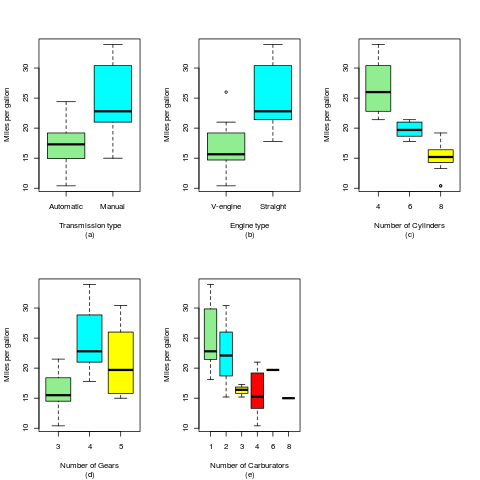

In [10]:
%%R
par(mfrow=c(2,3))
boxplot(mpg ~ am, mtcars, col=c("lightgreen", "cyan"), 
        ylab="Miles per gallon", xlab="Transmission type", sub="(a)")
boxplot(mpg ~ vs, mtcars, col=c("lightgreen", "cyan"), 
        ylab="Miles per gallon", xlab="Engine type", sub="(b)")
boxplot(mpg ~ cyl, mtcars, col=c("lightgreen", "cyan", "yellow"), 
        ylab="Miles per gallon", xlab="Number of Cylinders", sub="(c)")
boxplot(mpg ~ gear, mtcars, col=c("lightgreen", "cyan", "yellow"),
        ylab="Miles per gallon", xlab="Number of Gears", sub="(d)")
boxplot(mpg ~ carb, mtcars, col=c("lightgreen", "cyan", "yellow", "red", "maroon", "grey"),
        ylab="Miles per gallon", xlab="Number of Carburators", sub="(e)")
par(mfcol=c(1,1))

**Figure 2**: Scatterplots of `mpg` vs numeric variables (including correlation)\\label{fig:mpg-num}

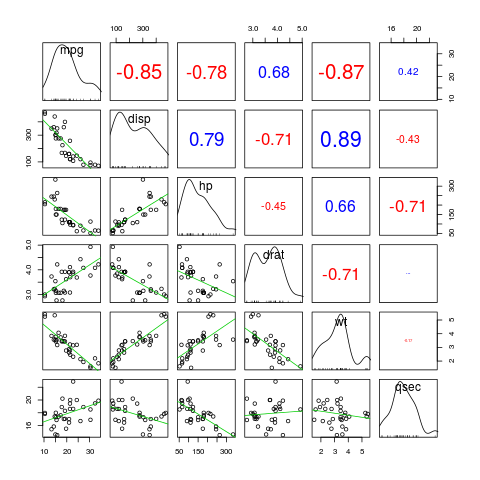

In [11]:
%%R
library(car)
panel.cor <- function(x, y, digits = 2, prefix = "", cex.cor, ...){
     usr <- par("usr"); on.exit(par(usr))
     par(usr = c(0, 1, 0, 1))
     r <- cor(x, y)
     txt <- paste0(prefix, round(r, digits))
     text(0.5, 0.5, txt, cex = 3 * abs(r), col=ifelse(r < 0, "red", "blue"))
}
spm(mtcars[,c("mpg", "disp", "hp", "drat", "wt","qsec")], smoother=FALSE,
    cex.labels=1.5, upper.panel=panel.cor)

**Figure 3**: Diagnostic plots for model 1: `mpg ~ am`
(a) Q-Q plot (black: automatic, red: manual)
(b) Residual vs Predicted plot (black: automatic, red: manual, blue: linear regression of residuals vs predicted)

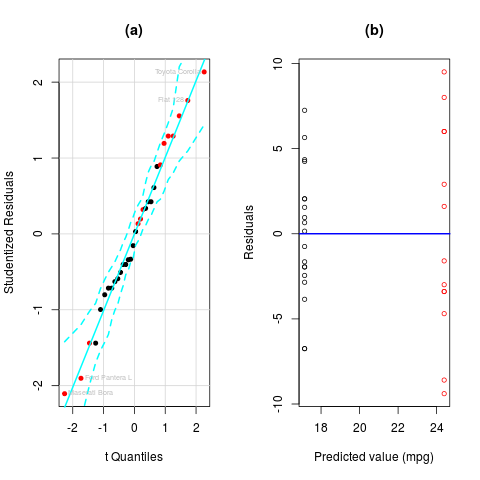

In [12]:
%%R
par(mfrow=c(1,2))
set.seed(123)
qqp1 <- qqPlot(model1, main="(a)", id.n=4,
               ylab="Studentized Residuals",
               pch=19, cex=0.8, id.cex=0.6, id.col="grey", col.lines="cyan",
               col=mtcars$am)
plot(resid(model1) ~ predict(model1), main="(b)",
               ylab="Residuals", xlab="Predicted value (mpg)",
               pch=1, cex=0.8, col=mtcars$am)
abline(lm(resid(model1) ~ predict(model1)), lwd=2, col="blue")
par(mfrow=c(1,1))

**Figure 4**: Diagnostic plots for model 2: `mpg ~ cyl + hp + wt + am`
(a) Q-Q plot (black: automatic, red: manual)
(b) Residual vs Predicted plot (black: automatic, red: manual, blue: linear regression of residuals vs predicted)

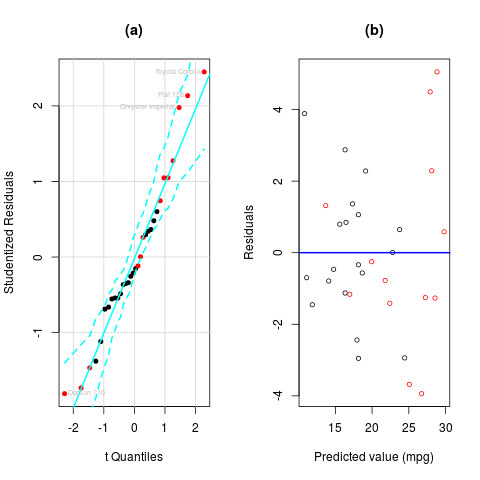

In [13]:
%%R
par(mfrow=c(1,2))
set.seed(123)
qqp2 <- qqPlot(model2, main="(a)", id.n=4,
               ylab="Studentized Residuals",
               pch=19, cex=0.8, id.cex=0.6, id.col="grey", col.lines="cyan", 
               col=mtcars$am)
plot(resid(model2) ~ predict(model2), main="(b)",
               ylab="Residuals", xlab="Predicted value (mpg)",
               pch=1, cex=0.8, col=mtcars$am)
abline(lm(resid(model2) ~ predict(model2)), lwd=2, col="blue")
par(mfrow=c(1,1))